# Прогнозирование оттока клиентов Телеком оператора

## Задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. 

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии. 

#### Contracts
СustomerID - единый ID пользователя  
BeginDate - дата начала действия контракта  
EndDate - дата завершения контракта (по данному признаку можно выявить разорвавших контракт)  
Type - способ оплаты  
PaperlessBilling - признак получения электронного чека  
PaymentMethod - способ оплаты  
MonthlyCharges - сумма оплаты в месяц  
TotalCharges - оплачено за весь период  

#### Personal
СustomerID - единый ID пользователя  
gender - пол пользователя  
SeniorCitizen - пенсионер (да или нет)  
Partner - наличие супруга(и)  
Dependents - наличие иждивенцев  

#### Internet
СustomerID - единый ID пользователя  
InternetService - способ подключения к интернету  
OnlineSecurity - блокировка сайтов  
OnlineBackup - облачное хранилище  
DeviceProtection - использование антивируса  
TechSupport - выделенная линия поддержки  
StreamingTV - подключение ТВ
StreamingMovies - каталог фильмов  

#### Phone
СustomerID - единый ID пользователя  
MultipleLines - услуга подключения к нескольким линиям 

## Цель
Построить модель бинарной классификации, которая будет определять пользователей с высокой вероятностью отказа от услуг компании. 

## KPI 
Первычный целевой признак - ROC-AUC > 0,85
Вторичный целевой признак - Accuracy 

In [4]:
!pip install phik

     |████████████████████████████████| 709 kB 2.2 MB/s eta 0:00:01


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import warnings
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
contracts = pd.read_csv('/datasets/final_provider/contract.csv')
contracts=contracts.rename(
    columns={
       'customerID': 'customer_id',
        'BeginDate': 'begin_date',
        'EndDate': 'end_date',
        'Type': 'type',
        'PaperlessBilling': 'paperless_billing',
        'PaymentMethod': 'payment_method',
        'MonthlyCharges': 'monthly_charges',
        'TotalCharges': 'total_charges'
    })
contracts = contracts.set_index('customer_id')
contracts

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45


In [4]:
contracts['end_date'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [5]:
print(contracts['begin_date'].min())
print(contracts['begin_date'].max())

2013-10-01
2020-02-01


In [6]:
contracts['total_charges'] = pd.to_numeric(contracts['total_charges'], errors='coerce')
contracts['begin_date'] = pd.to_datetime(contracts['begin_date'], format='%Y-%m-%d')
contracts.loc[contracts['end_date'] == 'No', 'end_date'] = np.nan


contracts['end_date'] = pd.to_datetime(contracts['end_date'], format='%Y-%m-%d %H:%M:%S')
contracts['end_date']=contracts['end_date'].fillna('2020-02-01')
contracts['end_date']=pd.to_datetime(contracts['end_date'])
contracts

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45


In [7]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 440.2+ KB


In [8]:
contracts['total_charges']=contracts['total_charges'].fillna(0)

In [9]:
contracts.describe()

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


В total_charges есть пропуски, но при этом они обусловлены тем, что срок оплаты еще не подошел, то есть это не пропуск, а осознанное значение, которое также важно учитывать. 

In [10]:
contracts['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [11]:
contracts['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

В базе Contracts представлены данные о договоре пользователя - даты заключения и расторжения, способы оплаты и суммы ежемесячного платежа, а также всего оплачено за весь период.

Всего представлено 7043 записей, пропуски отсутствуют. Все ID пользователей уникальны, значит на каждого пользователя только 1 запись. 

In [12]:
pers = pd.read_csv('/datasets/final_provider/personal.csv')
pers=pers.rename(
    columns={
       'customerID': 'customer_id',
        'SeniorCitizen': 'senior_citizen',
        'Partner': 'partner',
        'Dependents': 'dependents'
    })
pers = pers.set_index('customer_id')
pers

,gender,senior_citizen,partner,dependents
customer_id,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes
2234-XADUH,Female,0,Yes,Yes
4801-JZAZL,Female,0,Yes,Yes


In [13]:
pers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   int64 
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


База данных Personal представляет информацию о пользователе, заключившем договор. Также представлены 7043 ненулевыми записями.

In [14]:
inet = pd.read_csv('/datasets/final_provider/internet.csv')
inet=inet.rename(
    columns={
       'customerID': 'customer_id',
        'InternetService': 'internet_service',
        'OnlineSecurity': 'online_security',
        'OnlineBackup': 'online_backup',
        'DeviceProtection': 'device_protection',
        'TechSupport': 'tech_support',
        'StreamingTV': 'streaming_tv',
        'StreamingMovies': 'streaming_movies'
    })
inet = inet.set_index('customer_id')
inet

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...
6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
4801-JZAZL,DSL,Yes,No,No,No,No,No


In [15]:
inet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   object
 2   online_backup      5517 non-null   object
 3   device_protection  5517 non-null   object
 4   tech_support       5517 non-null   object
 5   streaming_tv       5517 non-null   object
 6   streaming_movies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [16]:
inet['internet_service'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

База данных Internet хранит информацию об услугах, которыми пользуются клиенты. В базе 5517 ненулевых записей, таким образом не по каждому клиенту есть информация об используемых услугах.

In [17]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
phone = phone.rename(
    columns={
       'customerID': 'customer_id',
        'MultipleLines': 'multiple_lines'
    })
phone = phone.set_index('customer_id')
phone

,multiple_lines
customer_id,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
...,...
2569-WGERO,No
6840-RESVB,Yes
2234-XADUH,Yes


In [18]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   multiple_lines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


База данных Phone предтсавляет данные о 6361 пользователях, поключивших услугу стационарного телефона. Из двух баз - Internet и Phone можем сделать вывод, что 4835 пользователей подключили как стационарный телефон, так и интернет.

# План работы

1. Предобработка данных. Анализ представленных данных их полнота и корректность. Поиск пропущенных или некорректно заполненных значений и их заполнение, поиск, описание и обработка выбросов в данных.  
2. Объединение баз в единую таблицу признаков, расчет дополнительных признаков, первичный анализ признаков, их зависимости между собой, отбор лишних данных, если такие возникнут. 
3. Выделение обучающей и тестовой выборки в соотношении 75/25, а также целевого признака в отдельную таблицу. 
4. Построение нескольких моделей, подбор гиперпараметром моделей, сравнение их эффективности с помощью кросс-валидации. Выбор оптимальной модели.
5. Проверка качества выбранной модели на тестовой выборке.
6. Описание проделанной работы, результатов и выводов исследования для заказчика.


# Часть 2. Создание модели 
  
<h2> 1. Предобработка данных. <a class="tocSkip"> </h2>

In [19]:
#Создадим колонку с целевым признаком в базе Contracts

contracts['target']=np.where(contracts.end_date == '2020-02-01', 0, 1)


#Создадим признак продолжительности контракта 

contracts['duration'] = (contracts['end_date'] - contracts['begin_date']).dt.days 


#Создадим столбец год заключения контракта

contracts['year']=pd.DatetimeIndex(contracts['begin_date']).year

#Теперь можем удалить столбцы начала и конец действия контракта, далее они нам не потребуются

contracts = contracts.drop(columns=['begin_date', 'end_date'], axis=1)

contracts.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,year
customer_id,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,2020
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,2017
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,2019
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,2016
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,2019


<h2> 2. Объединение баз в единую таблицу <a class="tocSkip"> </h2> 

In [20]:
#Объединим таблицы 

data=contracts.merge(pers, left_index = True, right_index = True, how='left')

data = data.merge(inet, left_index = True, right_index = True, how='left')

data = data.merge(phone, left_index = True, right_index = True, how='left')

data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,year,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,2020,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,2017,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,2019,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,2016,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,2019,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [21]:
#Добавим признак использование интернета
data['internet'] = np.where(((data.internet_service == 'DSL') | (data.internet_service == 'Fiber optic')), 1, 0)
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,year,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,2020,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,1
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,2017,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,2019,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,1
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,2016,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,2019,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,1


In [22]:
data[data.internet_service.isnull()].head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,year,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet
customer_id,,,,,,,,,,,,,,,,,,,,,
7469-LKBCI,Two year,No,Credit card (automatic),18.95,326.80,0,488,2018,Male,0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
8191-XWSZG,One year,No,Mailed check,20.65,1022.95,0,1584,2015,Female,0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
1680-VDCWW,One year,No,Bank transfer (automatic),19.80,202.25,0,365,2019,Male,0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
1066-JKSGK,Month-to-month,No,Mailed check,20.15,20.15,1,30,2019,Male,0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
7310-EGVHZ,Month-to-month,No,Bank transfer (automatic),20.20,20.20,0,31,2020,Male,0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0


In [23]:
#Добавим признак использования телефона
data['phone'] = np.where(data.multiple_lines.isna(), 0, 1)
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,year,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet,phone
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,2020,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,1,0
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,2017,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,1,1
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,2019,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,1
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,2016,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,1,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,2019,Female,0,...,Fiber optic,No,No,No,No,No,No,No,1,1


In [24]:
#В таблице образовались пропуски для тех пользователей, кто не приобретал конкретную услугу. 
#Соответственно заполним пропуски как No, так как услуга не используется

data=data.fillna('No')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   target             7043 non-null   int64  
 6   duration           7043 non-null   int64  
 7   year               7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support  

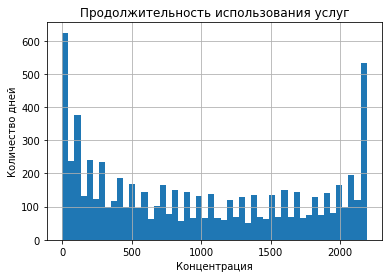

In [25]:
#Посмотрим распределение данных по продолжительности контракта

data['duration'].hist(bins=50, label = 'duration, days')
plt.title('Продолжительность использования услуг')
plt.ylabel('Количество дней')
plt.xlabel('Концентрация')
plt.show()
    


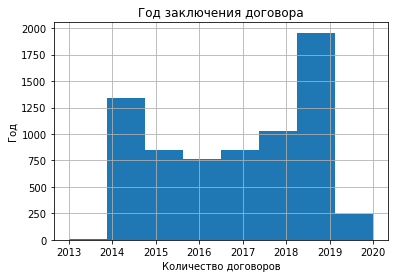

In [26]:
#Посмотрим распределение данных по годам заключения контракта

data['year'].hist(bins=8, label = 'years')
plt.title('Год заключения договора')
plt.ylabel('Год')
plt.xlabel('Количество договоров')
plt.show()

In [27]:
data[data['duration'] == 0]

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,year,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet,phone
customer_id,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,0.0,0,0,2020,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,No,1,0
3115-CZMZD,Two year,No,Mailed check,20.25,0.0,0,0,2020,Male,0,...,No,No,No,No,No,No,No,No,0,1
5709-LVOEQ,Two year,No,Mailed check,80.85,0.0,0,0,2020,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,1,1
4367-NUYAO,Two year,No,Mailed check,25.75,0.0,0,0,2020,Male,0,...,No,No,No,No,No,No,No,Yes,0,1
1371-DWPAZ,Two year,No,Credit card (automatic),56.05,0.0,0,0,2020,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,No,1,0
7644-OMVMY,Two year,No,Mailed check,19.85,0.0,0,0,2020,Male,0,...,No,No,No,No,No,No,No,No,0,1
3213-VVOLG,Two year,No,Mailed check,25.35,0.0,0,0,2020,Male,0,...,No,No,No,No,No,No,No,Yes,0,1
2520-SGTTA,Two year,No,Mailed check,20.00,0.0,0,0,2020,Female,0,...,No,No,No,No,No,No,No,No,0,1
2923-ARZLG,One year,Yes,Mailed check,19.70,0.0,0,0,2020,Male,0,...,No,No,No,No,No,No,No,No,0,1


Видим, что явно много договоров с очень короткой продолжительностью - около 0 и и очень длительной. Короткая продолжительность обусловлена резким ростом заключенных договоров в 2019 году (либо это особенность данных), длительная же может объясняться большим блоком лояльных клиентов, которые с компанией с основания. А также большим объемом заключенных договоров в 2014 году.   

Есть также новые контракты, заключенные с февраля 2020 года, в них нулевая продолжительность, но такие данные удалять некорректно, так как это важный признак, можно заметить, что среди тех, кто только заключил контракт - нет отказавшихся, важно обучить модель этим данным.   

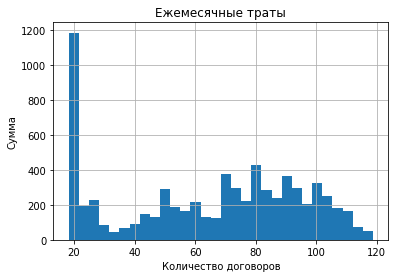

In [28]:
#Посмотрим также на распределение оплаты в месяц

data['monthly_charges'].hist(bins=30, label = 'monthly_charges')
plt.title('Ежемесячные траты')
plt.ylabel('Сумма')
plt.xlabel('Количество договоров')
plt.show()


Трат в районе нуля нет, это хорошо, значительная доля приходится на самый дешевый тариф, но это нельзя отнести к некачественным данным, это особенность потребления услуги. 

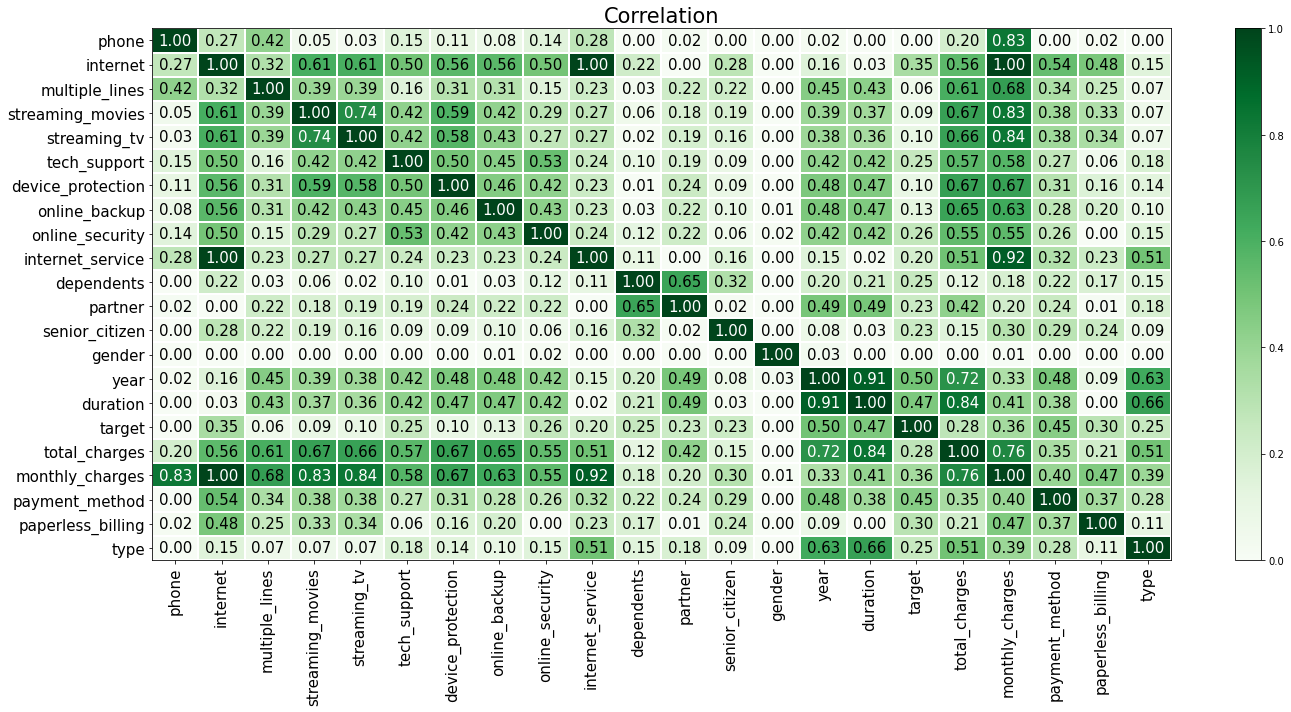

In [29]:
#Оценим коррелицию между признаками, чтобы избавиться от мультиколлинеарности
interval_cols = ['monthly_charges', 'total_charges', 'duration']
phik_overview = data.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Correlation", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

Мы видим очень высокую корреляцию ежемесячной стоимость от других признаков - что логично, оплата в месяц зависит от набора используемых функций, а также высокую зависимость продолжительности использования услуг и года заключения договора, что тоже логично, учитывая тот факт, что данные по отключившимся пользователям только за последние 4 месяца. Для того, чтобы не перегружать и не переобучать модель - уберем эти признаки.  

Есть также прямая коррекляция добавленных нами признаков использования интернета и телефона, но мы сделали это целенаправленно для интерпретируемости модели, поэтому их оставляем.

In [30]:
data=data.drop(['year', 'monthly_charges'], axis=1)

<h2> 3. Выделение обучающей и тестовой выборки, а также целевого признака <a class="tocSkip"> </h2>  

In [31]:
#Разделим на признаки и целевой признак
target = data['target']
features = data.drop(['target'], axis=1)

#Закодируем категориальные переменные порядковым кодированием 

encoder = OrdinalEncoder()
features = pd.DataFrame(encoder.fit_transform(features),
                            columns=features.columns)

#Выделим обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=120922)

print('features_train',features_train.shape)
print('target_train', target_train.shape)
print('features_test',features_test.shape)
print('target_test', target_test.shape)

features_train (5282, 19)
target_train (5282,)
features_test (1761, 19)
target_test (1761,)


In [32]:
features.head()

,type,paperless_billing,payment_method,total_charges,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet,phone
0,0.0,1.0,2.0,75.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,3.0,3625.0,74.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,1.0,3.0,537.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,3571.0,96.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,2.0,675.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [33]:
#Приведем признаки к единому масштабу
warnings.filterwarnings("ignore") 
scaler = StandardScaler()
numeric = ['total_charges', 'duration']
scaler.fit(features_train[numeric])

features_train[numeric]=scaler.transform(features_train[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])


features_train

,type,paperless_billing,payment_method,total_charges,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet,phone
1827,0.0,1.0,0.0,0.430367,0.498458,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3836,1.0,0.0,0.0,0.850291,1.270094,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
6893,0.0,0.0,1.0,-0.922722,-1.101273,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5930,2.0,1.0,0.0,1.441979,1.608861,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
4592,1.0,1.0,3.0,-0.396663,0.272614,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,0.0,1.0,2.0,-0.741729,-0.818968,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
5233,0.0,0.0,2.0,-0.454601,-1.007172,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
1466,0.0,1.0,2.0,-0.697634,-0.818968,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1854,0.0,1.0,2.0,-1.526715,-1.289477,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [34]:
#Проанализируем баланс классов

target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]


print(target_zeros.shape)
print(target_ones.shape)


(3881,)
(1401,)


В выборке присутствует дисбаланс классов, нужно будет учесть этот факт в зависимости от выбора модели в дальнейшем.

Мы заполнили пропуски в данных там, где это было необходимо. Пропуски в значении total_charges заполнили 0, так как пользователи еще не платили за услуги. Привели данные к корректному формату. 
Добавили дополнительные столбцы - с целевой метрикой, где 1 - контракт был разорван, 0 - контракт продолжается.   
Продолжительность использования услуг - на момент 1.02.202, а также год заключения контракта.  
  
А столбцы с датами заключения и окончания контракта удалили, так как они нам не потребуются.  
Далее объединили таблицы в общую по customer_id, те признаки, которые оказались незаполненными заполнили как No, то есть не используются этим клиентом. А также добавили два признака - подключение интернета и подключения телефона, несмотря на то, что они имеют прямую зависимость от других признаков, это поможет нам в интерпретации модели.  
  
Оценив корреляцию признаков, выявили высокую зависимость между monthly_charges и другими признаками используемых услуг, что логично, так как каждая услуга стоит определенную сумму, а также год заключения договора с продолжительностью - мы убрали данные признаки из данных для того, чтобы не переобучать и не усложнять модель.  

Из полученной таблицы мы выделили целевой признак и таблицу признаков, на которых будем обучать модель, закодировали категориальные переменные порядковым кодированием и разделили выборки на обучающую и тестовую в соотношении 75/25. 

Также важно отметить, что присутствует дисбаланс классов, что может повлиять на качество модели.

<h2> 4. Построение моделей, подбор гиперпараметров <a class="tocSkip"> </h2>  

In [35]:
#Протестируем Логистическую регрессию

target_ohe = data['target']
features_ohe = data.drop(['target'], axis=1)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, target_ohe, test_size=0.25, random_state=120922)

features_train_ohe = pd.get_dummies(features_train_ohe, drop_first=True)

model = LogisticRegression(random_state=120922, solver='liblinear', class_weight='balanced') 
model.fit(features_train, target_train)

print('ROC-AUC:', cross_val_score(model, features_train_ohe, target_train_ohe, cv=5, scoring='roc_auc').mean())
print('Accuracy:', cross_val_score(model, features_train_ohe, target_train_ohe, cv=5, scoring='accuracy').mean())

ROC-AUC: 0.843912427251753
Accuracy: 0.7440331054155558


In [36]:
#Посмотрим на интерпретацию модели
d = {'feature': features_train.columns, 'coefficient': model.coef_[0], 'odds': np.exp(model.coef_[0])}
df = pd.DataFrame(data=d)
df.sort_values(by='odds', ascending=False)

,feature,coefficient,odds
17,internet,3.135956,23.010629
9,internet_service,1.064778,2.900194
16,multiple_lines,0.427701,1.533727
15,streaming_movies,0.375242,1.455344
14,streaming_tv,0.321219,1.378808
1,paperless_billing,0.306174,1.358219
6,senior_citizen,0.211097,1.235032
12,device_protection,0.039734,1.040534
5,gender,0.018624,1.018798
2,payment_method,0.007158,1.007184


In [37]:
#Протестируем дерево решений 
model_tree = DecisionTreeClassifier(random_state=120922, max_depth=10, class_weight='balanced')
print('ROC-AUC:', cross_val_score(model_tree, features_train, target_train, cv=5, scoring='roc_auc').mean())
print('Accuracy:', cross_val_score(model_tree, features_train, target_train, cv=5, scoring='accuracy').mean())

ROC-AUC: 0.8154864327907475
Accuracy: 0.7495246337547662


In [38]:
#Подберем параметры для модели дерева решений
model_tree=DecisionTreeClassifier(random_state=120922)
parametrs = {'max_depth': range (1,20, 2),
            'min_samples_leaf': range (1,8),
            'min_samples_split': range (2,10,2) }

grid = GridSearchCV(model_tree, parametrs, cv=5, scoring='roc_auc', refit='roc_auc')
grid.fit(features_train, target_train)

model_tree = grid.best_estimator_
print('Best parameters:', grid.best_params_)
print('ROC-AUC:', grid.best_score_)
print('Accuracy:', cross_val_score(model_tree, features_train, target_train, cv=5, scoring='accuracy').mean())

Best parameters: {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}
ROC-AUC: 0.8447091916080798
Accuracy: 0.8063186261861759


In [44]:
grid.predict(features_test)

array([0, 0, 0, ..., 1, 0, 0])

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(target_test, grid.predict_proba(features_test)[:, 1])

0.851899775913697

In [45]:
roc_auc_score(target_test, grid.predict(features_test))

0.7451067880302219

In [39]:
#Обучим модель с оптимальными гиперпараметрами 
#model_tree=DecisionTreeClassifier(random_state=120922, max_depth=7, class_weight='balanced', min_samples_leaf=5, min_samples_split=2)

#print('ROC-AUC:', cross_val_score(model_tree, features_train, target_train, cv=5, scoring='roc_auc').mean())
#print('Accuracy:', cross_val_score(model_tree, features_train, target_train, cv=5, scoring='accuracy').mean())

In [40]:
#Протестируем LightGBM
model_LGBM = LGBMClassifier(num_leaves=10, n_estimators=20, max_depth=8, random_state=120922)
print('ROC-AUC:', cross_val_score(model_LGBM, features_train, target_train, cv=5, scoring='roc_auc').mean())
print('Accuracy:', cross_val_score(model_LGBM, features_train, target_train, cv=5, scoring='accuracy').mean())

ROC-AUC: 0.8657484782120737
Accuracy: 0.8231723574438806


In [41]:
#Подберем параметры для модели LightGBM
model_LGBM=LGBMClassifier(random_state=120922)
parametrs = {'max_depth': range (1,20, 4),
            'num_leaves': range (2,20, 4),
            'n_estimators': range (10,  100, 10) }

grid = GridSearchCV(model_LGBM, parametrs, cv=5, scoring='roc_auc', refit='roc_auc')
grid.fit(features_train, target_train)

model_LGBM = grid.best_estimator_
print('Best parameters:', grid.best_params_)
print('ROC-AUC:', grid.best_score_)
print('Accuracy:', cross_val_score(model_LGBM, features_train, target_train, cv=5, scoring='accuracy').mean())

Best parameters: {'max_depth': 9, 'n_estimators': 90, 'num_leaves': 18}
ROC-AUC: 0.8913775739587294
Accuracy: 0.8447532324187954


In [42]:
#Протестируем LightGBM c оптимальными гиперпараметрами
#model_LGBM = LGBMClassifier(num_leaves=18, n_estimators=90, max_depth=9, random_state=120922)
#print('ROC-AUC:', cross_val_score(model_LGBM, features_train, target_train, cv=5, scoring='roc_auc').mean())
#print('Accuracy:', cross_val_score(model_LGBM, features_train, target_train, cv=5, scoring='accuracy').mean())

In [43]:
model_CB = CatBoostClassifier(loss_function="Logloss",verbose=False, iterations=100, depth=6, learning_rate=0.3, random_state=120922) 
print('ROC-AUC:', cross_val_score(model_CB, features_train, target_train, cv=5, scoring='roc_auc').mean())
print('Accuracy:', cross_val_score(model_CB, features_train, target_train, cv=5, scoring='accuracy').mean())

ROC-AUC: 0.8860265255239088
Accuracy: 0.8388868581749376


In [44]:
#Подберем параметры для модели CatBoost
model_CB = CatBoostClassifier(loss_function="Logloss", learning_rate=0.3,  random_state=120922, verbose=False, iterations=200) 
parametrs = {'depth': range (1,20, 2)
             }

grid = GridSearchCV(model_CB, parametrs, cv=5, scoring='roc_auc', refit='roc_auc')
grid.fit(features_train, target_train)

model_CB = grid.best_estimator_
print('Best parameters:', grid.best_params_)
print('ROC-AUC:', grid.best_score_)
print('Accuracy:', cross_val_score(model_CB, features_train, target_train, cv=5, scoring='accuracy').mean())

Best parameters: {'depth': 3}
ROC-AUC: 0.9171466964617625
Accuracy: 0.8742893695708265


In [45]:
#Протестируем CatBoost c оптимальными гиперпараметрами
#model_CB = CatBoostClassifier(loss_function="Logloss", verbose=False, iterations=200, depth=3, learning_rate=0.3, random_state=120922) 
#print('ROC-AUC:', cross_val_score(model_CB, features_train, target_train, cv=5, scoring='roc_auc').mean())
#print('Accuracy:', cross_val_score(model_CB, features_train, target_train, cv=5, scoring='accuracy').mean())

Сравнив результаты 4х моделей - Логистической регресси, дерева решений, LightGBM и CatBoost - по ключевому KPI ROC-AUC наиболее высокий результат 0,92 показала модель CatBoost, она не только корректнее других предсказывает тех, кто уйдет - (истинно-положительный результат), но и корретнее других предсказывает тех, кто останется (истинно-отрицательные результаты), но также эта модель с точки зрения accuracy показала максимальный результат - в 87% случаев модель предсказывет корректно. Логично, что обе метрики имеют прямую зависимость, так как чем чаще модель дает истинно-положительный/истинно-отрицательный результат - тем выше ее точность. 

Таким образом, мы рекомендуем в дальнейшем использовать модель CatBoost, количество итераций - 200, глубина - 3, lerning rate - 0.3.

In [46]:
#Добавим к интерпретации модели результаты дерева решений
model_tree.fit(features_train, target_train)
df['importances_tree'] = model_tree.feature_importances_


result = permutation_importance(model_tree, features_train, target_train, random_state=12092022)
df['importances_tree_permutation']=result.importances_mean


#ДОбавим к интерпретации модели результаты LightGBM
model_LGBM.fit(features_train, target_train)
df['importances_LGBM'] = model_LGBM.feature_importances_

#Добавим к интерпретации модели результаты CatBoost
model_CB.fit(features_train, target_train)
df['importances_CB'] = model_CB.feature_importances_


In [47]:
numeric_columns = ['odds',
                   'importances_tree',
                   'importances_tree_permutation',
                  'importances_LGBM',
                  'importances_CB']
df.style.background_gradient(cmap='Blues', axis=0, subset=numeric_columns )


,feature,coefficient,odds,importances_tree,importances_tree_permutation,importances_LGBM,importances_CB
0,type,-0.844900,0.429600,0.441979,0.049527,58,10.540487
1,paperless_billing,0.306174,1.358219,0.004763,0.001742,32,0.817751
2,payment_method,0.007158,1.007184,0.002406,0.000000,53,1.518365
3,total_charges,-0.585303,0.556937,0.062608,0.022832,372,7.311827
4,duration,-0.276204,0.758658,0.287292,0.095494,647,65.440609
5,gender,0.018624,1.018798,0.002136,0.000000,37,0.805497
6,senior_citizen,0.211097,1.235032,0.000000,0.000000,22,0.337954
7,partner,-0.013084,0.987001,0.000000,0.000000,13,0.035268
8,dependents,-0.200011,0.818722,0.002675,0.000492,39,0.146850
9,internet_service,1.064778,2.900194,0.165629,0.058273,66,5.613516


Можем заметить, что модели показали разное значение факторов - для логистической регрессии основной вклад вносит использование интернета и его функционал соответственно, а для моделей, основанных на деревьях, на первый план выходят параметры договора и его продолжительность. Но нас в первую очередь интересует результат CatBoost, как модели, показавшей самый высокий результат.  

Но можно определенно сказать, что высокое влияение имеют продолжительность взаимодействия с компанией(чем она выше - тем меньше шанс отказа), общая оплаченная сумма (хотя это несомненно взаимосвязанные факторы, влияние соответствующее), тип оплаты и использование интернет подключения - при использование оптоволокна шанс отключение выше, чем при использовании DSL (при учете, что фактор наличия интернета в целом рассматривается отдельно).

<h2> 5. Проверка модели на тестовой выборке <a class="tocSkip"> </h2>  

In [48]:
#Оценим метрики качества модели на тестовой выборке, которую мы отделили ранее

model=model_CB

model.fit(features_train, target_train) 
probabilities_test = model.predict_proba(features_test)[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_test)

print("ROC_AUC:", auc_roc)

predictions=model.predict(features_test)
print("Accuracy:", accuracy_score(target_test, predictions))

ROC_AUC: 0.9302523119228454
Accuracy: 0.8949460533787621


<h2> Вывод <a class="tocSkip"> </h2>  

Для поиска оптимального решения мы протестировали 4 различных модели - логистическая регрессия, дерево решений, LightGBM и CatBoost.  

Модели градиентного бустинга показали наиболее высокие результаты - ROC_AUC и Accuracy

Для того, чтобы определить гиперпараметры, для улучшения качества моделей мы использовали метод Gridsearch, что позволило значительно улучшить изначальные показатели моделей, так например ROC-AUC LightGBM вырос на 0.04 - с 0.85 до 0.89 после подбора оптимальных гиперпараметров. И по результатам этой операции удалось добиться высоких показателей качества модели CatBoost - после подбора оптимальных гиперпараметров - глубина - 3, количество итераций - 200, удалось достичь ROC - AUC 0.92 на обучающей выборке и 0.88 accuracy,  то есть в 88% случаев модель корректно предсказываем - собирается ли пользователь отказаться от услуг компании.   
    
Валидация на тестовой выборке также подтвердила выскоий результат данной модели - ROC-AUC-0.93 и Accuracy - 0.89, что позволяет нам подтвердить эффективность модели.
    
В итоге Мы рекомендуем использовать в дальнейшем модель CatBoost, количество итераций - 200, глубина - 3, lerning rate - 0.3.

# Часть 3. Отчет 


Перед нами стояла следующая <b>задача</b>:

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.   

<b>Цель проекта:</b> Построить модель бинарной классификации, которая будет определять пользователей с высокой вероятностью отказа от услуг компании.   

<b>KPI:</b>
Первычный целевой признак - ROC-AUC > 0,85
Вторичный целевой признак - Accuracy   

Ддя достижения результата было проведено 5 этапов работы (в соответствии с изначальным планом):

1. Предобработка данных. Анализ представленных данных их полнота и корректность. Поиск пропущенных или некорректно заполненных значений и их заполнение, поиск, описание и обработка выбросов в данных.  
2. Объединение баз в единую таблицу признаков, расчет дополнительных признаков, первичный анализ признаков, их зависимости между собой, отбор лишних данных, если такие возникнут. 
3. Выделение обучающей и тестовой выборки в соотношении 75/25, а также целевого признака в отдельную таблицу. 
4. Построение нескольких моделей, подбор гиперпараметром моделей, сравнение их эффективности с помощью кросс-валидации. Выбор оптимальной модели.
5. Проверка качества выбранной модели на тестовой выборке.  

Все этапы, которые изначально были запланированы, реализованы в ходе проекта. Выработанный план позволил последовательно пройти все необходимые шаги и прийти к высокому результату по целевой метрике.

Данные представлены 4 базами - контракты, персональные данные, услуги интернет соединения, услуги телефонной связи.  
Всего представлено 7043 записей, базы связаны через уникальный Customer ID.  

Мы заполнили пропуски в данных там, где это было необходимо. Пропуски в значении total_charges заполнили 0, так как пользователи еще не платили за услуги. Привели данные к корректному формату. 
Добавили дополнительные столбцы - с целевой метрикой, где 1 - контракт был разорван, 0 - контракт продолжается.   
Продолжительность использования услуг - на момент 1.02.202, а также год заключения контракта.  
  
А столбцы с датами заключения и окончания контракта удалили, так как они нам не потребуются.  
Далее объединили таблицы в общую по customer_id, те признаки, которые оказались незаполненными заполнили как No, то есть не используются этим клиентом. А также добавили два признака - подключение интернета и подключения телефона, несмотря на то, что они имеют прямую зависимость от других признаков, это поможет нам в интерпретации модели.  
  
Оценив корреляцию признаков, выявили высокую зависимость между monthly_charges и другими признаками используемых услуг, что логично, так как каждая услуга стоит определенную сумму, а также год заключения договора с продолжительностью - мы убрали данные признаки из данных для того, чтобы не переобучать и не усложнять модель.  

Из полученной таблицы мы выделили целевой признак и таблицу признаков, на которых будем обучать модель, закодировали категориальные переменные порядковым кодированием и разделили выборки на обучающую и тестовую в соотношении 75/25.   

Для поиска оптимального решения мы протестировали 4 различных модели - <b>логистическая регрессия, дерево решений, LightGBM и CatBoost.</b>  

Модели градиентного бустинга показали наиболее высокие результаты - ROC_AUC и Accuracy

Для того, чтобы определить гиперпараметры, для улучшения качества моделей мы использовали метод Gridsearch, что позволило значительно улучшить изначальные показатели моделей, так например ROC-AUC LightGBM вырос на 0.04 - с 0.85 до 0.89 после подбора оптимальных гиперпараметров. И по результатам этой операции удалось добиться высоких показателей качества модели CatBoost - после подбора оптимальных гиперпараметров - глубина - 3, количество итераций - 200, удалось достичь ROC - AUC 0.92 на обучающей выборке и 0.88 accuracy,  то есть в 88% случаев модель корректно предсказываем - собирается ли пользователь отказаться от услуг компании.   

Основная сложность, с которой мы столкнулись в ходе разработки проекта - скорость расчета моделей и подбора гиперпараметров, в дальнейшем при усложнении расчетов можно использовать GPU для расчетов.   
    
Валидация на тестовой выборке также подтвердила выскоий результат данной модели - ROC-AUC-0.93 и Accuracy - 0.89, что позволяет нам подтвердить эффективность модели.
    
<b>В итоге Мы рекомендуем использовать в дальнейшем модель CatBoost, количество итераций - 200, глубина - 3, lerning rate - 0.3.</b>  

Дополнительно мы также проанализировали интерпретацию модели. Можно определенно сказать, что высокое влияение имеют продолжительность взаимодействия с компанией(чем она выше - тем меньше шанс отказа), общая оплаченная сумма (хотя это несомненно взаимосвязанные факторы, влияние соответствующее), тип оплаты и использование интернет подключения - при использование оптоволокна шанс отключение выше, чем при использовании DSL (при учете, что фактор наличия интернета в целом рассматривается отдельно).